<a href="https://colab.research.google.com/github/jhleee/langgraph-exercise/blob/master/LangGraph_exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install langgraph langchain-google-genai

In [2]:
# gemini 기본 셋팅

import os
from google.colab import userdata

api_key = userdata.get('GOOGLE_API_KEY')


from langchain_google_genai import ChatGoogleGenerativeAI
# 모델 로드
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_output_tokens=200,
    google_api_key=api_key,
)
llm.invoke("Hello")

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7dcc65f6-3005-4582-9a7f-3f336df1322f-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [26]:
import re
import requests

def start(text):
  prompt = f"""입력된 질문이 날씨에 관한 내용인지 확인하고 아래 지시사항을 따르시오.
  1. 질문이 날씨와 관련이 없다면 <END/>로 답변하시오.
  2. 질문에 지리 정보가 있다면, 해당 지역을 시 단위로 영문으로 표기하여 <LOC> 태그를 사용하여 답변하시오.

  응답예시 1: <LOC>Seoul</LOC>
  응답예시 2: <END/>

  질문:
  {text}
  """
  return llm.invoke(prompt)

# 날씨 검색을 위해 도시이름을 먼저 추출해야함
def extract_loc(response):
  content = response.content
  loc = re.search(r'<LOC>(.*?)</LOC>', content)
  if loc:
    return loc.group(1)
  else:
    return None

# 위치 정보를 검색
def search_geo(loc):
  res = requests.get(f"https://geocoding-api.open-meteo.com/v1/search?name={loc}")
  return res.json()['results'][0]

# meteo api를 사용해서 날씨 정보
def find_weather(loc):
  res = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={loc['latitude']}&longitude={loc['longitude']}&hourly=temperature_2m&timezone=Asia%2FTokyo&forecast_days=1&format=json&timeformat=unixtime")
  return res.json()

# 데이터 보여주기
def data_visualize(weather):
  data = list(zip(weather['hourly']['time'], weather['hourly']['temperature_2m']))
  x_values = [item[0] for item in data]
  y_values = [item[1] for item in data]

  plt.plot(x_values, y_values)
  plt.xlabel("Unix Time")
  plt.ylabel("Temperature")
  plt.title("Temperature over Time")
  return plt

def end(_):
  return "END"

In [48]:
# ASK -> FIN 의 간단한 그래프를 구성한다.

from langgraph.graph import Graph

workflow = Graph()
workflow.add_node("START", start)
workflow.add_node("FIND_CITY", extract_loc)
workflow.add_node("SEARCH_GEO", search_geo)
workflow.add_node("FIND_WEATHER", find_weather)
workflow.add_node("VISUALIZE", data_visualize)
workflow.add_node("END", end)

workflow.add_edge("START", "FIND_CITY")

def is_valid_city(city):
  return city is not None

workflow.add_conditional_edges("FIND_CITY", is_valid_city, {
    True: "SEARCH_GEO",
    False: "END"
})

workflow.add_edge("SEARCH_GEO", "FIND_WEATHER")
workflow.add_edge("FIND_WEATHER", "VISUALIZE")
workflow.add_edge("VISUALIZE", "END")

workflow.set_entry_point("START")
workflow.set_finish_point("END")

# 마지막엔 컴파일 !

app = workflow.compile()

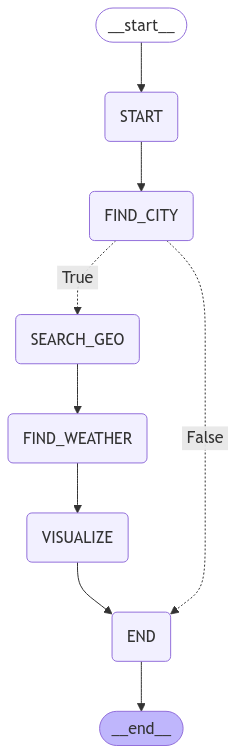

In [49]:
# Graph Visualization
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [50]:
for output in app.stream("한국의 수도는?"):
  # key:value의 dict를 yield 해준다.
  print("* Strem ...")
  for k, v in output.items():
    print(f"NODE[{k}]--\n{v}")

* Strem ...
NODE[START]--
content='<END/>\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-0658e0cc-429c-49a1-b4f1-50d6a3f996b7-0' usage_metadata={'input_tokens': 138, 'output_tokens': 4, 'total_tokens': 142, 'input_token_details': {'cache_read': 0}}
* Strem ...
NODE[FIND_CITY]--
None
* Strem ...
NODE[END]--
END


* Strem ...
NODE[START]--
content='<LOC>Seoul</LOC>\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-bc4631d4-837b-4f2a-b8ab-190ab1f807bd-0' usage_metadata={'input_tokens': 141, 'output_tokens': 8, 'total_tokens': 149, 'input_token_details': {'cache_read': 0}}
* Strem ...
NODE[FIND_CITY]--
Seoul
* Strem ...
NODE[SEARCH_GEO]--
{'id': 1835848, 'name': 'Seoul', 'latitude': 37.566, 'longitude': 126.9784, 'elevation': 38.0, 'feature_code': 'PPLC', 'country_code': 'KR', 'admin1_id': 1835847, 'timezone': 'Asia/Seoul', 'population': 10349312, 'country_id': 1835841, 'country': 'South Korea', 'admin1': 'Seoul'}
* Strem ...
NODE[FIND_WEATHER]--
{'latitude': 37.55, 'longitude': 127.0, 'generationtime_ms': 0.02193450927734375, 'utc_offset_seconds': 32400, 'timezone': 'Asia/Tokyo', 'timezone_abbreviation': 'JST', 'elevation': 27.0, 'hourly_units': {'time': 'unixtime', 'temperature_2m': '°C'

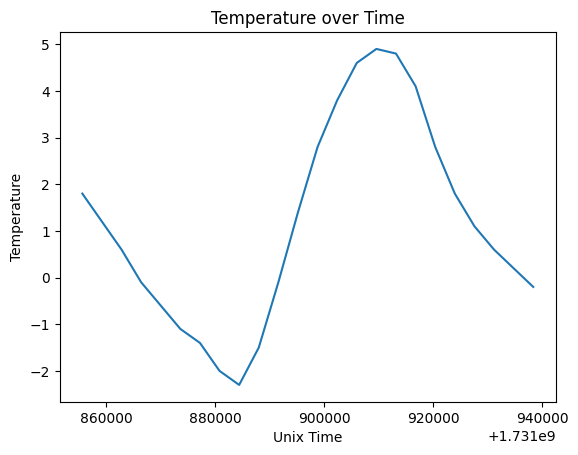

In [51]:
for output in app.stream("한국의 수도의 날씨는?"):
  # key:value의 dict를 yield 해준다.
  print("* Strem ...")
  for k, v in output.items():
    print(f"NODE[{k}]--\n{v}")